In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal
from astropy.io import fits

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


<IPython.core.display.Javascript object>


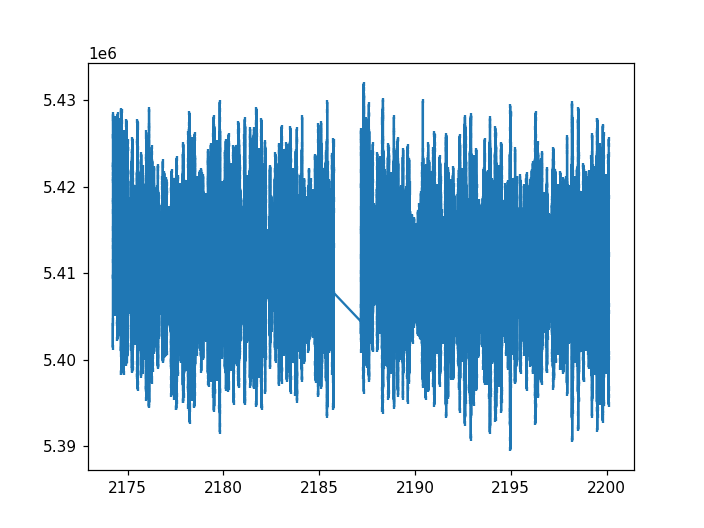

In [15]:
### TESS 2020_2021 data import ###
hdul = fits.open("tess2020324010417-s0032-0000000270577175-0200-s_lc.fits")

#SAP_FLUX, PDCSAP_FLUX, SAP_BKG, QUALITY
data = hdul[1].data
time = data['TIME']
flux = data['SAP_FLUX']
flux_error = data['SAP_FLUX_ERR']
index = np.argwhere((time<2240) & (~np.isnan(flux)) & (data["QUALITY"] == 0))
time = np.ndarray.flatten(time[index])
flux = np.ndarray.flatten(flux[index])
flux_error = np.ndarray.flatten(flux_error[index])
plt.figure()
plt.errorbar(time,flux,yerr=flux_error,markersize=1,capsize=0,fmt="-")
plt.show()

In [16]:
### GP Model ###
bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=1., log_Q=2.5, log_omega0=5.80,bounds=bounds)


gp = celerite.GP(kernel,mean=np.mean(flux))
gp.compute(time,yerr=flux_error)


print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -2253035.7018925226
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])



In [17]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


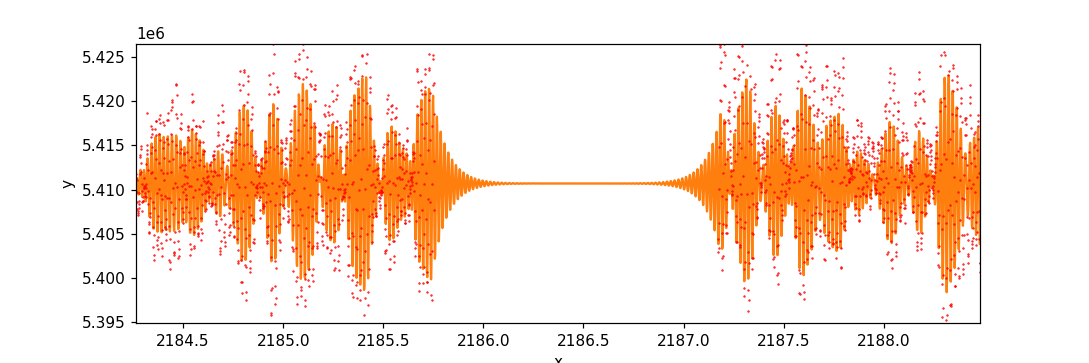

array([5407266.89155026, 5405754.55070011, 5405746.1856046 , ...,
       5417676.10542589, 5419416.32849802, 5418421.28793768])

In [18]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.nanmin(flux),np.nanmax(flux))
plt.show()
pred_mean

In [19]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: 142292.4473895015
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.41036401,  5.28816599, 25.85293259])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 23
   status: 0
  success: True
        x: array([8.88318369, 2.94175385, 5.73251096])
Final log-likelihood: -142292.4473895015
[7209.70769817   18.949051    308.7435389 ]
Parameters: OrderedDict([('kernel:log_S0', 8.883183688288652), ('kernel:log_Q', 2.941753851132881), ('kernel:log_omega0', 5.732510971073635)])


In [20]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


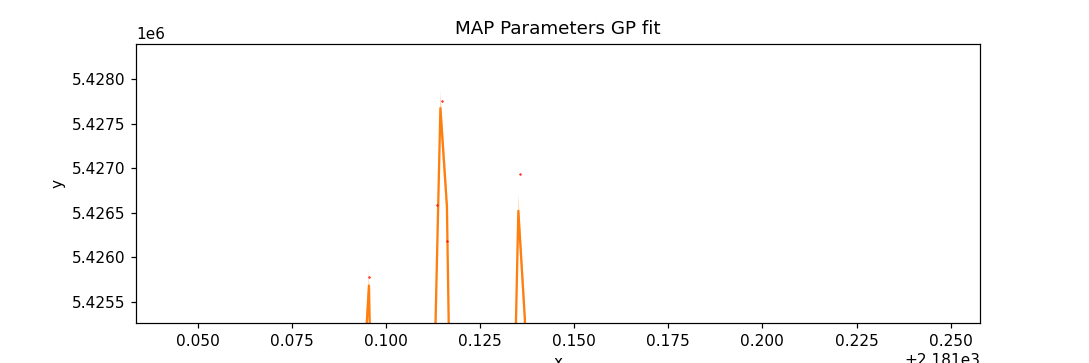

In [21]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux-np.mean(flux),yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [22]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [23]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7)) :
        return 0
    return -np.inf

In [24]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [25]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

Running burn-in...


100%|██████████| 500/500 [05:18<00:00,  1.57it/s]


Running production...


100%|██████████| 5000/5000 [51:54<00:00,  1.61it/s] 

Finished


In [26]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', 8.861959704034362), ('kernel:log_Q', 3.037272526787763), ('kernel:log_omega0', 5.733922552977438)])
Final MCMC log likelihood: -142293.29706150992


In [27]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[7058.30138162   20.84830243  309.17966652]


49.2074722303992

In [28]:
P = 1/f
print("periode :",P*24*60,"min")

periode : 29.263848247632655 min


In [29]:
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


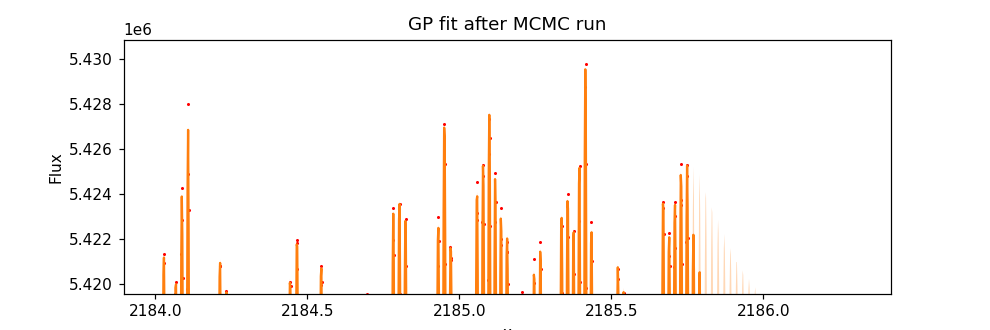

In [30]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>


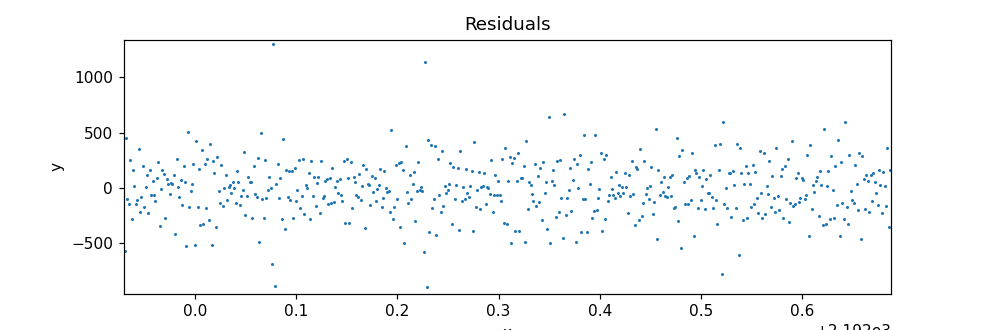

In [31]:
### Résidus ###
pred_mean, pred_var = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux - pred_mean,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux - pred_mean),np.max(flux - pred_mean))
plt.title("Residuals")
plt.show()

<IPython.core.display.Javascript object>


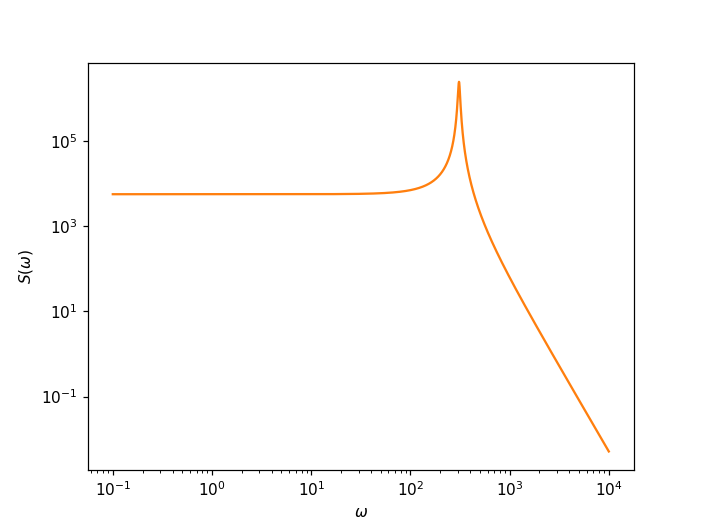

In [32]:
### PSD en fonction de omega ###
plt.figure()
omega = np.exp(np.linspace(np.log(0.1), np.log(10000), 5000))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd, color=color)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$")
plt.show()

(41728, 3)


<IPython.core.display.Javascript object>


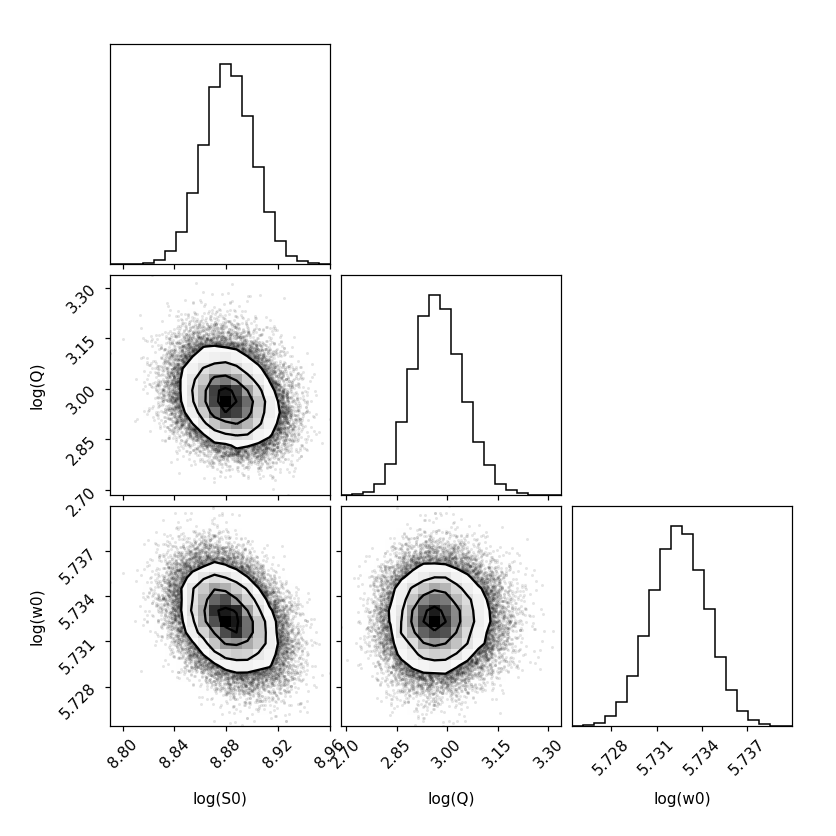

In [33]:
### Posteriors ###
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)"]
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
plt.show()

In [34]:
tau = sampler.get_autocorr_time()
print(tau)

[37.84420096 36.21781688 37.42856946]


<IPython.core.display.Javascript object>


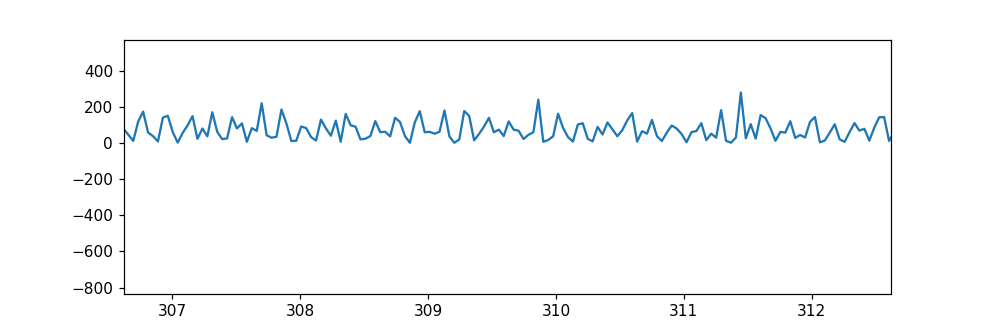

freq: 44.86215223398517 d-1
periode 32.09832627934272 min


In [35]:
### Périodogramme des résidus ###
fs = len(time)/(time[-1] - time[0])
f,pxx = signal.periodogram(flux - pred_mean,fs)
plt.figure(figsize=(9,3))
plt.plot(f,pxx)
plt.show()
idx = np.argmax(pxx)
print("freq:", f[idx],"d-1")
print("periode",1/f[idx]*60*24,"min")

In [36]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_flux = rv_data[:,1]
rv_error = rv_data[:,2]
index = np.argwhere(rv_time>=3333)
rv_flux = np.ndarray.flatten(rv_flux[index])
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])

<IPython.core.display.Javascript object>


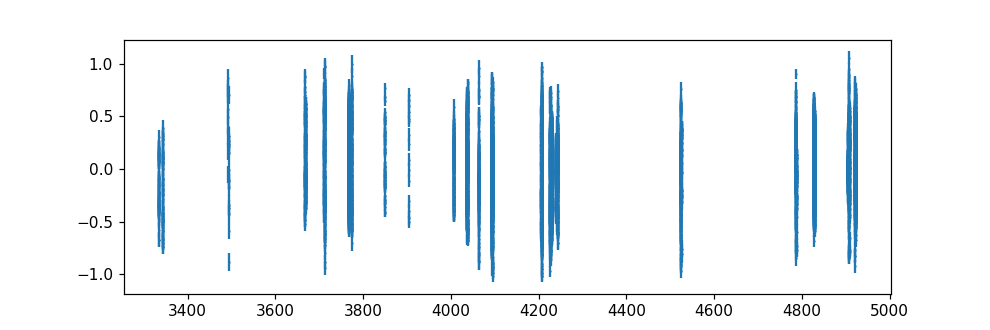

In [37]:
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=1,capsize=0,fmt='.')
plt.show()

<IPython.core.display.Javascript object>


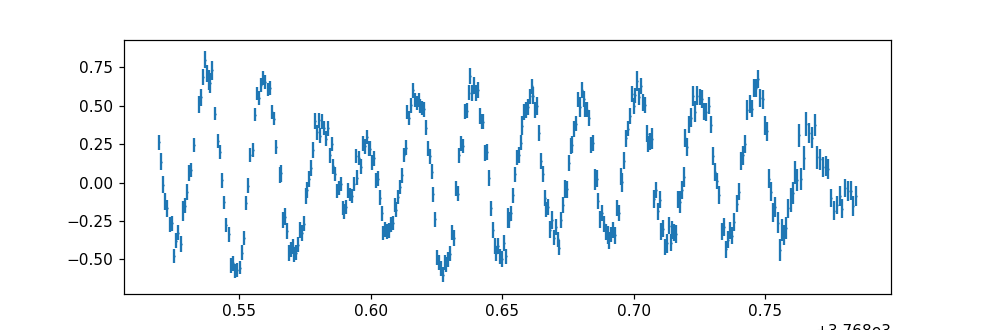

In [38]:
### Data à traiter ###
index = np.argwhere((rv_time>3768)&(rv_time<3769))
rv_flux = np.ndarray.flatten(rv_flux[index])
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=1,capsize=0,fmt='.')
plt.show()

In [52]:
### Récupération des hyperparamètres ###
p = gp.get_parameter_vector()

In [53]:
### GP Model ###
bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=p[0], log_Q=p[1], log_omega0=p[2],bounds=bounds)


gp = celerite.GP(kernel,fit_mean=True)
gp.compute(rv_time,yerr=rv_error)


print("Initial log likelihood: {0}".format(gp.log_likelihood(rv_flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: 393.34946791687025
parameter_dict:
OrderedDict([('kernel:log_S0', -11.135805830740374), ('kernel:log_Q', 3.071788675968151), ('kernel:log_omega0', 5.696074347650501), ('mean:value', 0.0)])



In [54]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [55]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7) and (-10 < params[3] < 10)) :
        return 0
    return -np.inf

In [56]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [57]:
### MCMC ###
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(rv_time,rv_flux))

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

  1%|          | 3/500 [00:00<00:18, 26.55it/s]

Running burn-in...


100%|██████████| 500/500 [00:14<00:00, 34.15it/s]


Running production...


100%|██████████| 15000/15000 [07:16<00:00, 34.39it/s]

Finished


In [66]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(rv_flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', -10.87328540480248), ('kernel:log_Q', 4.467448307348256), ('kernel:log_omega0', 5.711942403527463), ('mean:value', 0.05842078165924084)])
Final MCMC log likelihood: 413.55796770097254


In [59]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[1.89579838e-05 8.71340997e+01 3.02457994e+02 1.06016100e+00]


48.1376847509767

In [60]:
P = 1/f
print("periode :",P*24*60,"min")

periode : 29.914193161746997 min


In [69]:
x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


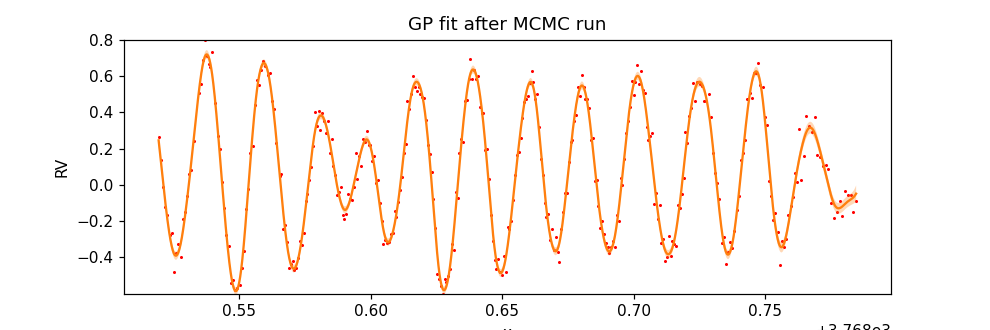

In [70]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("RV")
plt.ylim(np.min(rv_flux),np.max(rv_flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>


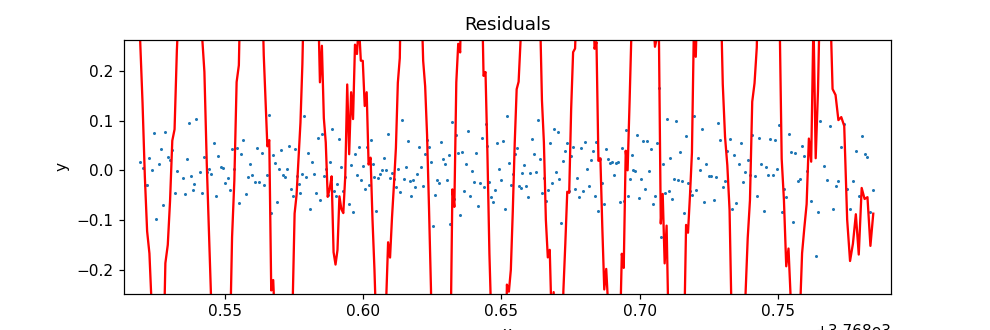

In [71]:
### Résidus ###
pred_mean, pred_var = gp.predict(rv_flux, rv_time, return_var=True)
pred_std = np.sqrt(pred_var)
res = rv_flux - pred_mean
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.plot(rv_time,rv_flux,c="r")
plt.scatter(rv_time,res,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(rv_flux),np.max(rv_flux))
plt.title("Residuals")
plt.show()

(127104, 4)


C:\ProgramData\Anaconda3\lib\site-packages\corner\core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


<IPython.core.display.Javascript object>


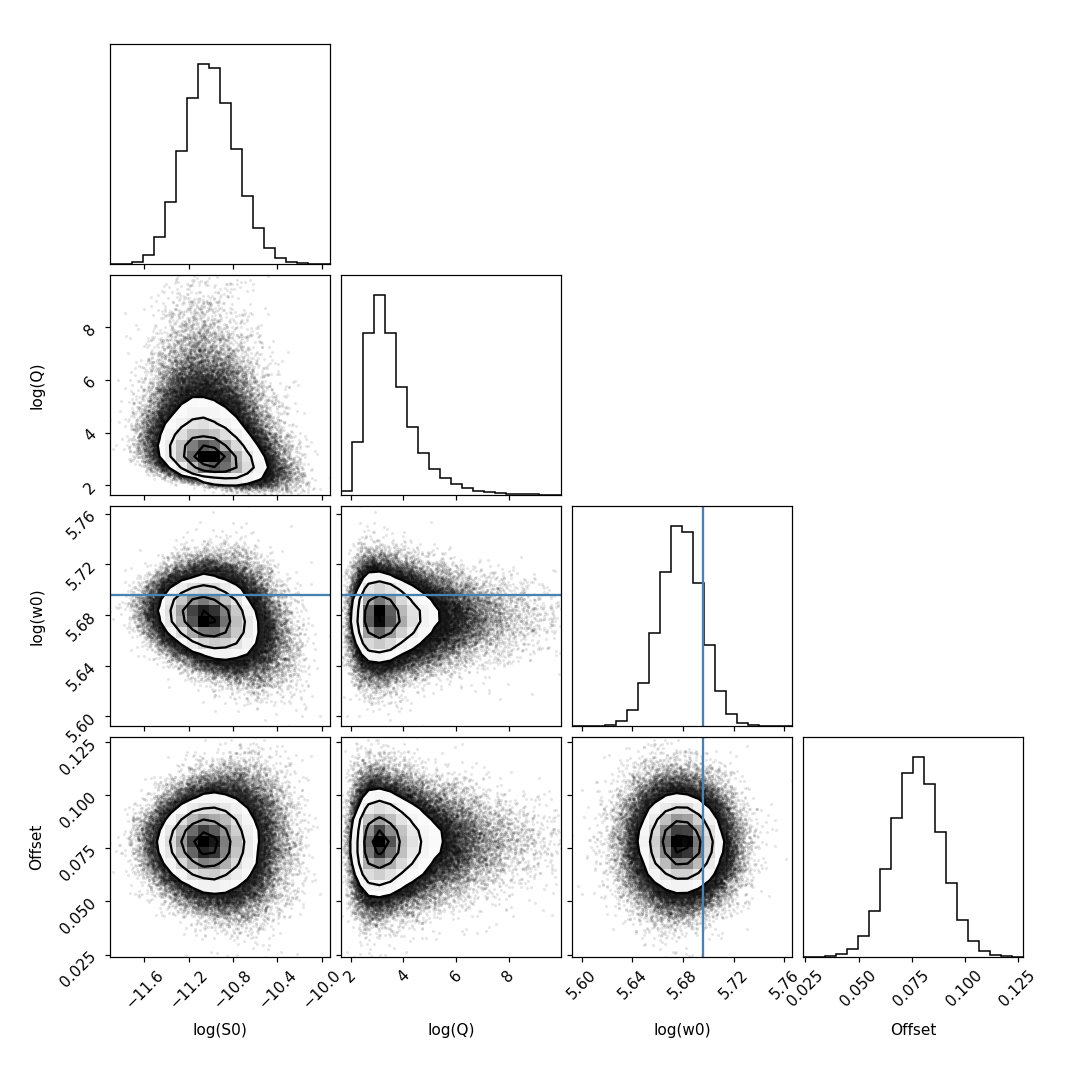

In [65]:
### Posteriors ###
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)","Offset"]
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4),None])
plt.show()

In [67]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>